In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%pip install tensorflow
%pip install tensorflow-hub
%pip install pydotplus
%pip install pydot
%pip install keras
%pip install openpyxl



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from keras.regularizers import l2
from keras.utils import to_categorical
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import optimizers

from keras.utils import plot_model
import tensorflow_hub as hub
import tensorflow as tf
#from tf.keras.utils import plot_model



import pydotplus as pyd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [66]:
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)

def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [225]:
train = pd.read_csv('train_clean.csv')
train = train.sample(frac=1)
cv = pd.read_csv('cv_clean.csv')
cv = cv.sample(frac=1)
test = pd.read_csv('test_clean.csv')
test = test.sample(frac=1)

train.head()

is_sarcastic                                               text
9839              0            things about anxiety nobody talks about
9487              0   cops write super friendly letter to wanted woman
12048             0  why model carmen carrera does not always want ...
9992              0                        nukes and the global schism
3565              1  man trying to enter conversation spends few mi...

In [226]:
train['is_sarcastic'].value_counts()

is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

In [227]:
test['is_sarcastic'].value_counts()

is_sarcastic
0    2997
1    2345
Name: count, dtype: int64

In [228]:
train['text'] = train['text'].astype(str)
cv['text'] = cv['text'].astype(str)
test['text'] = test['text'].astype(str)

#train['author'] = train['author'].astype(str)
#cv['author'] = cv['author'].astype(str)
#test['author'] = test['author'].astype(str)

In [229]:
t = Tokenizer()
t.fit_on_texts(train['text'].values)
vocab_size = len(t.word_index) + 1
print(vocab_size)

22885


In [230]:
encoded_comments_train = t.texts_to_sequences(train['text'])
encoded_comments_cv = t.texts_to_sequences(cv['text'])
encoded_comments_test = t.texts_to_sequences(test['text'])

In [231]:
lengths = []

for doc in encoded_comments_train:
    lengths.append(len(doc))

In [232]:
np.percentile(lengths, 99.9)

22.0

In [233]:
max_length = 70
padded_comments_train = pad_sequences(encoded_comments_train, maxlen=max_length, padding='post')
padded_comments_cv = pad_sequences(encoded_comments_cv, maxlen=max_length, padding='post')
padded_comments_test = pad_sequences(encoded_comments_test, maxlen=max_length, padding='post')

In [234]:
y_train = train['is_sarcastic'].values
y_cv = cv['is_sarcastic'].values
y_test = test['is_sarcastic'].values

y_train = to_categorical(y_train, num_classes=2)
y_cv = to_categorical(y_cv, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [235]:
w2v_model = KeyedVectors.load_word2vec_format('/Users/chayahaugland/Desktop/Github : Ling 111/ling111-final-project-sarcasm-detection/GoogleNews-vectors-negative300.bin', binary=True)

In [236]:
# create a weight matrix for words in training docs
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector
        
embedding_matrix_w2v.shape

(22885, 300)

In [237]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model 1: Baseline

In [238]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 70, 300)        │     6,865,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 67, 50)         │        60,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 33, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 31, 100)        │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected (Dense)         │ (None, 100)            │       150,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,090,952 (27.05 MB)

 Trainable params: 225,452 (880.67 KB)

 Non-trainable params: 6,865,500 (26.19 MB)

None


In [239]:
#keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model.png', show_shapes=True)
from tensorflow.keras import backend as K


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [240]:
tensorboard = TensorBoard(log_dir='model_01')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_01.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [241]:
c = optimizers.Adam(learning_rate = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h1 = model_01.fit(padded_comments_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(padded_comments_cv, y_cv))

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.5829 - f1_m: 0.5829 - loss: 0.6632
Epoch 1: val_f1_m improved from -inf to 0.75508, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - acc: 0.5831 - f1_m: 0.5831 - loss: 0.6631 - val_acc: 0.7546 - val_f1_m: 0.7551 - val_loss: 0.5144 - learning_rate: 1.0000e-04
Epoch 2/50
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7734 - f1_m: 0.7734 - loss: 0.4843
Epoch 2: val_f1_m improved from 0.75508 to 0.81923, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - acc: 0.7735 - f1_m: 0.7735 - loss: 0.4841 - val_acc: 0.8194 - val_f1_m: 0.8192 - val_loss: 0.4081 - learning_rate: 1.0000e-04
Epoch 3/50
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8190 - f1_m: 0.8190 - loss: 0.4034
Epoch 3: val_f1_m improved from 0.81923 to 0.84623, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc: 0.8190 - f1_m: 0.8190 - loss: 0.4034 - val_acc: 0.8463 - val_f1_m: 0.8462 - val_loss: 0.3548 - learning_rate: 1.0000e-04
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8406 - f1_m: 0.8406 - loss: 0.3642
Epoch 4: val_f1_m improved from 0.84623 to 0.85678, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.8406 - f1_m: 0.8406 - loss: 0.3642 - val_acc: 0.8574 - val_f1_m: 0.8568 - val_loss: 0.3284 - learning_rate: 1.0000e-04
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8603 - f1_m: 0.8603 - loss: 0.3305
Epoch 5: val_f1_m improved from 0.85678 to 0.88832, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.8603 - f1_m: 0.8603 - loss: 0.3305 - val_acc: 0.8882 - val_f1_m: 0.8883 - val_loss: 0.2868 - learning_rate: 1.0000e-04
Epoch 6/50
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8813 - f1_m: 0.8813 - loss: 0.2907
Epoch 6: val_f1_m improved from 0.88832 to 0.89717, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.8813 - f1_m: 0.8813 - loss: 0.2908 - val_acc: 0.8978 - val_f1_m: 0.8972 - val_loss: 0.2561 - learning_rate: 1.0000e-04
Epoch 7/50
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8947 - f1_m: 0.8947 - loss: 0.2622
Epoch 7: val_f1_m improved from 0.89717 to 0.91750, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc: 0.8946 - f1_m: 0.8946 - loss: 0.2622 - val_acc: 0.9178 - val_f1_m: 0.9175 - val_loss: 0.2209 - learning_rate: 1.0000e-04
Epoch 8/50
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9124 - f1_m: 0.9124 - loss: 0.2302
Epoch 8: val_f1_m improved from 0.91750 to 0.93317, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.9123 - f1_m: 0.9123 - loss: 0.2302 - val_acc: 0.9332 - val_f1_m: 0.9332 - val_loss: 0.1898 - learning_rate: 1.0000e-04
Epoch 9/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9278 - f1_m: 0.9278 - loss: 0.2004
Epoch 9: val_f1_m improved from 0.93317 to 0.94898, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.9277 - f1_m: 0.9277 - loss: 0.2004 - val_acc: 0.9491 - val_f1_m: 0.9490 - val_loss: 0.1563 - learning_rate: 1.0000e-04
Epoch 10/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9415 - f1_m: 0.9415 - loss: 0.1697
Epoch 10: val_f1_m improved from 0.94898 to 0.95403, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.9415 - f1_m: 0.9415 - loss: 0.1697 - val_acc: 0.9539 - val_f1_m: 0.9540 - val_loss: 0.1416 - learning_rate: 1.0000e-04
Epoch 11/50
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9549 - f1_m: 0.9549 - loss: 0.1413
Epoch 11: val_f1_m improved from 0.95403 to 0.97452, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.9549 - f1_m: 0.9549 - loss: 0.1413 - val_acc: 0.9744 - val_f1_m: 0.9745 - val_loss: 0.1034 - learning_rate: 1.0000e-04
Epoch 12/50
330/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9695 - f1_m: 0.9695 - loss: 0.1116
Epoch 12: val_f1_m improved from 0.97452 to 0.97991, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.9694 - f1_m: 0.9694 - loss: 0.1117 - val_acc: 0.9798 - val_f1_m: 0.9799 - val_loss: 0.0832 - learning_rate: 1.0000e-04
Epoch 13/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9789 - f1_m: 0.9789 - loss: 0.0867
Epoch 13: val_f1_m improved from 0.97991 to 0.98996, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.9789 - f1_m: 0.9789 - loss: 0.0867 - val_acc: 0.9899 - val_f1_m: 0.9900 - val_loss: 0.0605 - learning_rate: 1.0000e-04
Epoch 14/50
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9862 - f1_m: 0.9862 - loss: 0.0673
Epoch 14: val_f1_m improved from 0.98996 to 0.99163, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - acc: 0.9862 - f1_m: 0.9862 - loss: 0.0673 - val_acc: 0.9916 - val_f1_m: 0.9916 - val_loss: 0.0489 - learning_rate: 1.0000e-04
Epoch 15/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9915 - f1_m: 0.9915 - loss: 0.0507
Epoch 15: val_f1_m improved from 0.99163 to 0.99498, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - acc: 0.9915 - f1_m: 0.9915 - loss: 0.0507 - val_acc: 0.9949 - val_f1_m: 0.9950 - val_loss: 0.0427 - learning_rate: 1.0000e-04
Epoch 16/50
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9947 - f1_m: 0.9947 - loss: 0.0367
Epoch 16: val_f1_m improved from 0.99498 to 0.99777, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.9947 - f1_m: 0.9947 - loss: 0.0367 - val_acc: 0.9978 - val_f1_m: 0.9978 - val_loss: 0.0243 - learning_rate: 1.0000e-04
Epoch 17/50
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9970 - f1_m: 0.9970 - loss: 0.0262
Epoch 17: val_f1_m improved from 0.99777 to 0.99888, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.9970 - f1_m: 0.9970 - loss: 0.0262 - val_acc: 0.9989 - val_f1_m: 0.9989 - val_loss: 0.0169 - learning_rate: 1.0000e-04
Epoch 18/50
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9990 - f1_m: 0.9990 - loss: 0.0174
Epoch 18: val_f1_m improved from 0.99888 to 0.99963, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.9990 - f1_m: 0.9990 - loss: 0.0174 - val_acc: 0.9996 - val_f1_m: 0.9996 - val_loss: 0.0113 - learning_rate: 1.0000e-04
Epoch 19/50
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9995 - f1_m: 0.9995 - loss: 0.0134
Epoch 19: val_f1_m did not improve from 0.99963
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.9995 - f1_m: 0.9995 - loss: 0.0134 - val_acc: 0.9996 - val_f1_m: 0.9996 - val_loss: 0.0086 - learning_rate: 1.0000e-04
Epoch 20/50
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9996 - f1_m: 0.9996 - loss: 0.0084
Epoch 20: val_f1_m improved from 0.99963 to 0.99981, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.9996 - f1_m: 0.9996 - loss: 0.0084 - val_acc: 0.9998 - val_f1_m: 0.9998 - val_loss: 0.0060 - learning_rate: 1.0000e-04
Epoch 21/50
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9996 - f1_m: 0.9996 - loss: 0.0070
Epoch 21: val_f1_m did not improve from 0.99981
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - acc: 0.9996 - f1_m: 0.9996 - loss: 0.0070 - val_acc: 0.9998 - val_f1_m: 0.9998 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 22/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.9999 - f1_m: 0.9999 - loss: 0.0044
Epoch 22: val_f1_m did not improve from 0.99981
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - acc: 0.9999 - f1_m: 0.9999 - loss: 0.0044 - val_acc: 0.9998 - val_f1_m: 0.9998 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 23/50
330/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 1.0000 - f1_m: 1.0000 - loss: 0.0030
Epoch 23: val_f1_m did not improve from 0.99981
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 1.0

In [242]:
score_1 = model_01.evaluate(padded_comments_test, y_test)
score_1

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8202 - f1_m: 0.8202 - loss: 1.0427


[1.0931097269058228, 0.8097554445266724, 0.8098090887069702]

In [243]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_comments_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[[2543  454]
 [ 562 1783]]


<Axes: >

In [244]:
y_pred = np.argmax(model_01.predict(padded_comments_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Identify incorrect predictions
incorrect_indices = np.where(y_pred != y_true)[0]

# Build a list of misclassified examples from the DataFrame
misclassified_data = {
    "Index": incorrect_indices,
    "Headline": [test.iloc[i]["text"] for i in incorrect_indices],
    "True Label": [y_true[i] for i in incorrect_indices],
    "Predicted Label": [y_pred[i] for i in incorrect_indices],
}

# Create DataFrame and export to Excel
df_misclassified = pd.DataFrame(misclassified_data)
df_misclassified.to_excel("misclassified_examples.xlsx", index=False)

#Sort by confidence
"""y_probs = model_01.predict(padded_comments_test)  # shape: (n_samples, n_classes)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Step 2: Find misclassified indices
incorrect_indices = np.where(y_pred != y_true)[0]

# Step 3: Extract relevant info for each misclassified sample
misclassified_data = {
    "Index": incorrect_indices,
    "Original Comment": [test.iloc[i]["text"] for i in incorrect_indices],
    "True Label": [y_true[i] for i in incorrect_indices],
    "Predicted Label": [y_pred[i] for i in incorrect_indices],
    "Confidence": [y_probs[i][y_pred[i]] for i in incorrect_indices],  # confidence in the wrong prediction
}

# Step 4: Create DataFrame and sort by confidence (descending)
df_misclassified = pd.DataFrame(misclassified_data)
df_misclassified = df_misclassified.sort_values(by="Confidence", ascending=False)

# Step 5: Export to Excel (or CSV)
df_misclassified.to_excel("misclassified_sorted_by_confidence.xlsx", index=False)"""

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


'y_probs = model_01.predict(padded_comments_test)  # shape: (n_samples, n_classes)\ny_pred = np.argmax(y_probs, axis=1)\ny_true = np.argmax(y_test, axis=1)\n\n# Step 2: Find misclassified indices\nincorrect_indices = np.where(y_pred != y_true)[0]\n\n# Step 3: Extract relevant info for each misclassified sample\nmisclassified_data = {\n    "Index": incorrect_indices,\n    "Original Comment": [test.iloc[i]["text"] for i in incorrect_indices],\n    "True Label": [y_true[i] for i in incorrect_indices],\n    "Predicted Label": [y_pred[i] for i in incorrect_indices],\n    "Confidence": [y_probs[i][y_pred[i]] for i in incorrect_indices],  # confidence in the wrong prediction\n}\n\n# Step 4: Create DataFrame and sort by confidence (descending)\ndf_misclassified = pd.DataFrame(misclassified_data)\ndf_misclassified = df_misclassified.sort_values(by="Confidence", ascending=False)\n\n# Step 5: Export to Excel (or CSV)\ndf_misclassified.to_excel("misclassified_sorted_by_confidence.xlsx", index=Fals

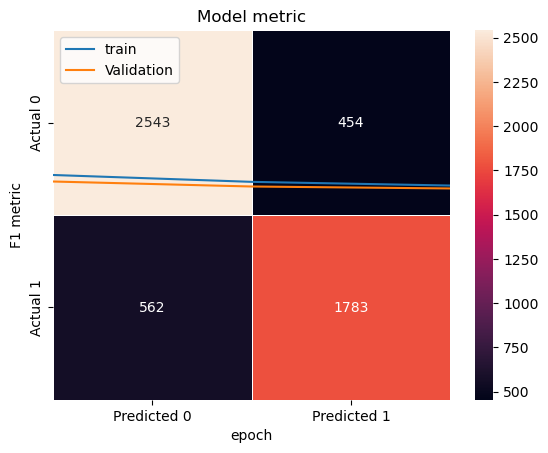

In [245]:
plt.plot(h1.history['f1_m'][1:])
plt.plot(h1.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

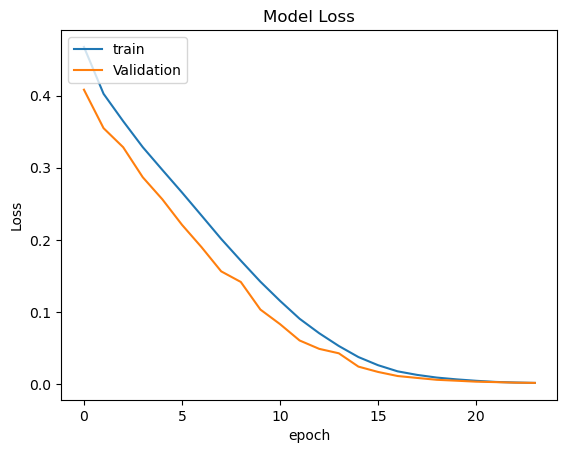

In [246]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 2: Baseline + Sentiments

In [247]:

sentiment_model = load_model('sentiment_model.h5', custom_objects={'f1_m': f1_m})
sentiment_tokenizer = openfromfile('/kaggle/input/pickles/sentiment_tokenizer')

TypeError: Error when deserializing class 'Embedding' using config={'name': 'embedding_5', 'trainable': False, 'dtype': 'float32', 'input_dim': 16673, 'output_dim': 200, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None, 'dtype': 'float32'}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None, 'input_shape': [None, None]}.

Exception encountered: <class 'keras.src.initializers.random_initializers.RandomUniform'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None, 'dtype': 'float32'}, 'registered_name': None}.

Exception encountered: RandomUniform.__init__() got an unexpected keyword argument 'dtype'

In [ ]:
encoded_comments_train_1 = sentiment_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv_1 = sentiment_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test_1 = sentiment_tokenizer.texts_to_sequences(test['text'])

In [ ]:
padded_comments_train_1 = pad_sequences(encoded_comments_train_1, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv_1, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test_1, maxlen=140, padding='post')

In [ ]:
output_layer_sentiment = 'fully_connected'
intermediate_layer_model_1 = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train = intermediate_layer_model_1.predict(padded_comments_train_1)
intermediate_output_cv = intermediate_layer_model_1.predict(padded_comments_cv_1)
intermediate_output_test = intermediate_layer_model_1.predict(padded_comments_test_1)

In [ ]:
intermediate_output_train.shape

In [ ]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_sent = Input(shape=(100,), name='sentiment_input')
concat = concatenate([dense, input_sent])

out = Dense(2, activation='softmax')(concat)

model_02 = Model(inputs=[input_data, input_sent], outputs=[out])

print(model_02.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 67, 50)       60050       embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 33, 50)       0           conv1d_3[0][0]                   
____________________________________________________________________________________________

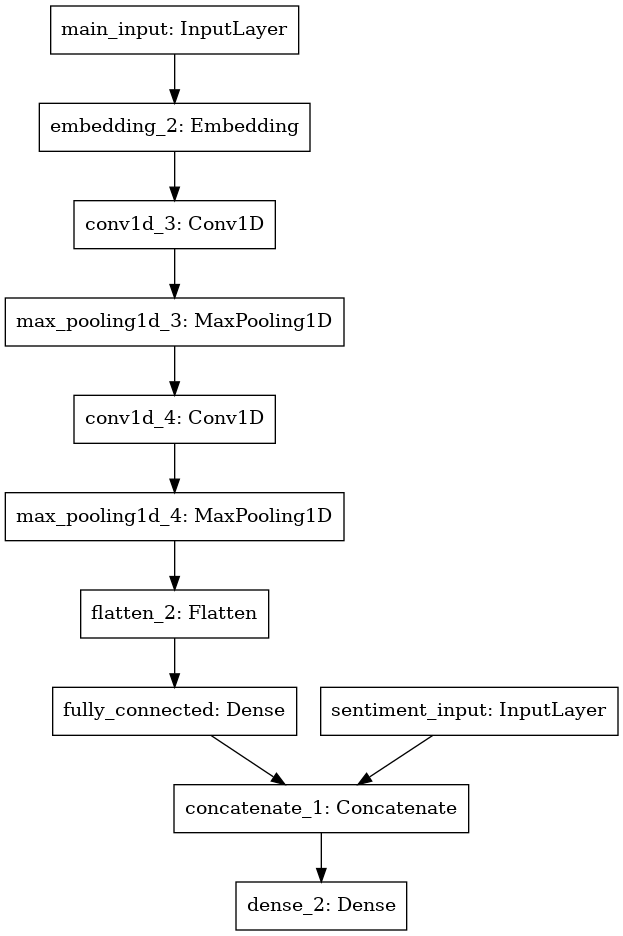

In [ ]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_02, to_file='model_02.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_02')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_02.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 10,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_02.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv)]
X_test = [padded_comments_test, np.array(intermediate_output_test)]

h2 = model_02.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_2 = model_02.evaluate(X_test, y_test)
score_2

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_02.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h2.history['f1_m'][1:])
plt.plot(h2.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h2.history['loss'][1:])
plt.plot(h2.history['val_loss'][1:])
plt.title('Model Los')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 3: Baseline + Emotion_1

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_1_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles/emotion_tokenizer')

In [ ]:
encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['text'])

In [ ]:
padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

In [ ]:
output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
intermediate_output_train.shape

In [ ]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_emo])

out = Dense(2, activation='softmax')(concat)

model_03 = Model(inputs=[input_data, input_emo], outputs=[out])

print(model_03.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 67, 50)       60050       embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 33, 50)       0           conv1d_5[0][0]                   
____________________________________________________________________________________________

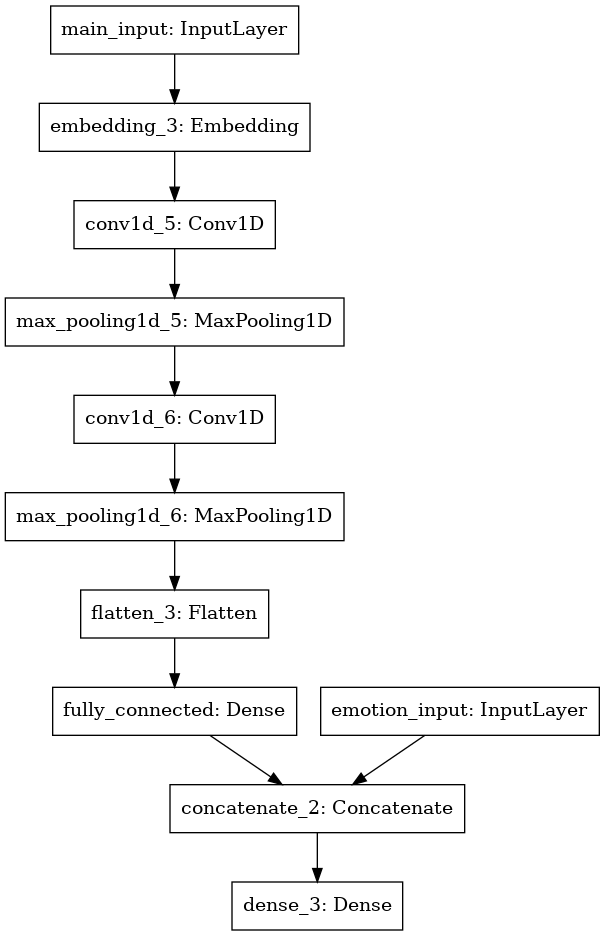

In [ ]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_03, to_file='model_03.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_03')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_03.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_03.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv)]
X_test = [padded_comments_test, np.array(intermediate_output_test)]

h3 = model_03.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_3 = model_03.evaluate(X_test, y_test)
score_3

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_03.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h3.history['f1_m'][1:])
plt.plot(h3.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h3.history['loss'][1:])
plt.plot(h3.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 4: Baseline + Emotion_2

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_2_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles1/emotion_tokenizer_1')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/input/contextmodels/emotion_model_2_1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['text'])

In [ ]:
padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=300, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=300, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=300, padding='post')

In [ ]:
output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
intermediate_output_train.shape

In [ ]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_emo])

out = Dense(2, activation='softmax')(concat)

model_04 = Model(inputs=[input_data, input_emo], outputs=[out])

print(model_04.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 67, 50)       60050       embedding_4[0][0]                
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 33, 50)       0           conv1d_7[0][0]                   
____________________________________________________________________________________________

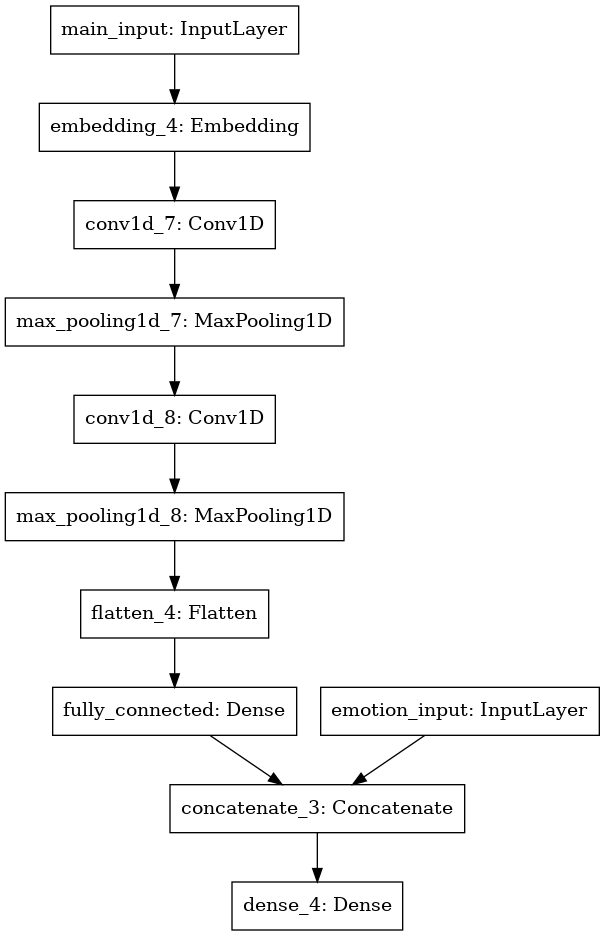

In [ ]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_04, to_file='model_04.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_04')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_04.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_04.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv)]
X_test = [padded_comments_test, np.array(intermediate_output_test)]

h4 = model_04.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_4 = model_04.evaluate(X_test, y_test)
score_4

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_04.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h4.history['f1_m'][1:])
plt.plot(h4.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h4.history['loss'][1:])
plt.plot(h4.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 5: Baseline + Sentiment + Emotion_1

In [ ]:
sentiment_model = load_model('/kaggle/input/contextmodels/sentiment_model.h5', custom_objects={'f1_m': f1_m})
sentiment_tokenizer = openfromfile('/kaggle/input/pickles/sentiment_tokenizer')

encoded_comments_train = sentiment_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = sentiment_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = sentiment_tokenizer.texts_to_sequences(test['text'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

output_layer_sentiment = 'fully_connected'
intermediate_layer_model = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train_1 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_1 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_1 = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_1_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles/emotion_tokenizer')

encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['text'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train_2 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_2 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_2 = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_sent = Input(shape=(100,), name='sentimet_input')
input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_sent, input_emo])

out = Dense(2, activation='softmax')(concat)

model_05 = Model(inputs=[input_data, input_sent, input_emo], outputs=[out])

print(model_05.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 67, 50)       60050       embedding_5[0][0]                
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 33, 50)       0           conv1d_9[0][0]                   
____________________________________________________________________________________________

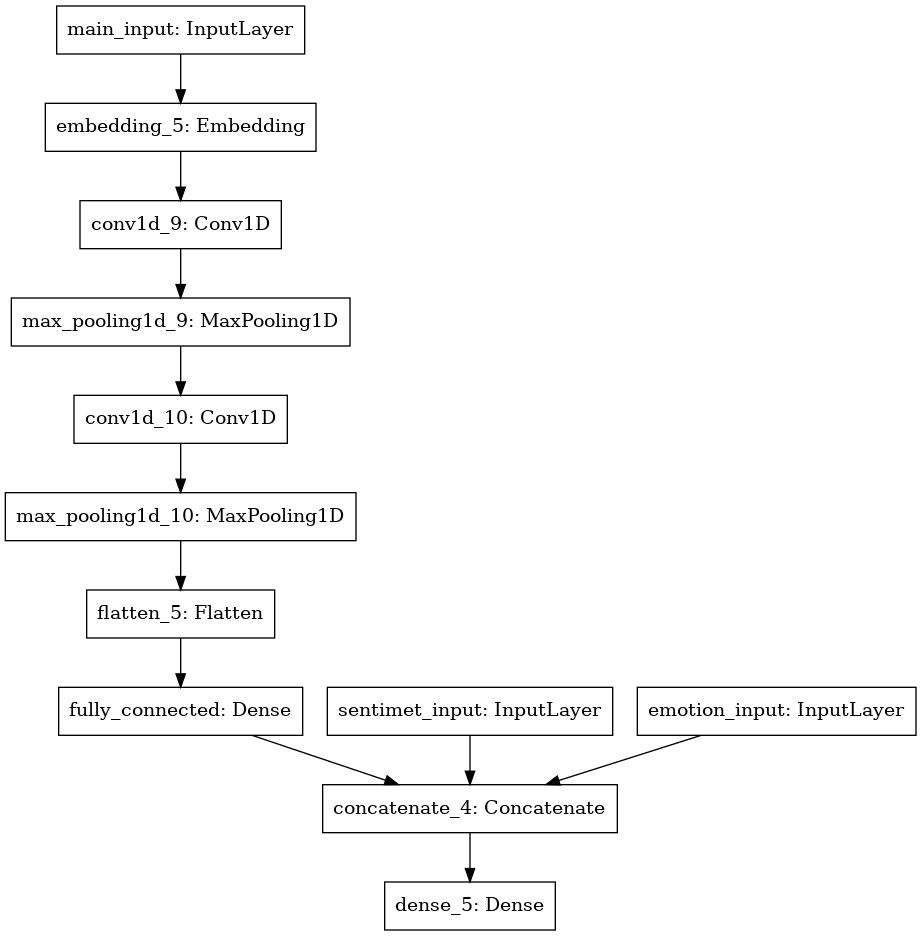

In [ ]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_05, to_file='model_05.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_05')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_05.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_05.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train_1), np.array(intermediate_output_train_2)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv_1), np.array(intermediate_output_cv_2)]
X_test = [padded_comments_test, np.array(intermediate_output_test_1), np.array(intermediate_output_test_2)]

h5 = model_05.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_5 = model_05.evaluate(X_test, y_test)
score_5

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_05.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h5.history['f1_m'][1:])
plt.plot(h5.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h5.history['loss'][1:])
plt.plot(h5.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 6: Baseline + Sentiment + Emotion_2

In [ ]:
del w2v_model

In [ ]:
sentiment_model = load_model('/kaggle/input/contextmodels/sentiment_model.h5', custom_objects={'f1_m': f1_m})
sentiment_tokenizer = openfromfile('/kaggle/input/pickles/sentiment_tokenizer')

encoded_comments_train = sentiment_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = sentiment_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = sentiment_tokenizer.texts_to_sequences(test['text'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

output_layer_sentiment = 'fully_connected'
intermediate_layer_model = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train_1 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_1 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_1 = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_2_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles1/emotion_tokenizer_1')

encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['text'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=300, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=300, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=300, padding='post')

output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train_2 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_2 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_2 = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_sent = Input(shape=(100,), name='sentimet_input')
input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_sent, input_emo])

out = Dense(2, activation='softmax')(concat)

model_06 = Model(inputs=[input_data, input_sent, input_emo], outputs=[out])

print(model_06.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 67, 50)       60050       embedding_6[0][0]                
__________________________________________________________________________________________________
max_pooling1d_11 (MaxPooling1D) (None, 33, 50)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [ ]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_06, to_file='model_06.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_06')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_06.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_06.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train_1), np.array(intermediate_output_train_2)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv_1), np.array(intermediate_output_cv_2)]
X_test = [padded_comments_test, np.array(intermediate_output_test_1), np.array(intermediate_output_test_2)]

h6 = model_06.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_6 = model_06.evaluate(X_test, y_test)
score_6

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_06.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h6.history['f1_m'][1:])
plt.plot(h6.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h6.history['loss'][1:])
plt.plot(h6.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Conclusions

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model', 'F1-Score', '% of sarcastic comments correcly classified']
x.add_row(['1', '0.7234', '73.58'])
x.add_row(['2', '0.7179', '71.78'])
x.add_row(['3', '0.7242', '71.75'])
x.add_row(['4', '0.7235', '72.07'])
x.add_row(['5', '0.7222', '70.71'])
x.add_row(['6', '0.7215', '72.10'])

In [ ]:
print(x)

+-------+----------+---------------------------------------------+
| Model | F1-Score | % of sarcastic comments correcly classified |
+-------+----------+---------------------------------------------+
|   1   |  0.7234  |                    73.58                    |
|   2   |  0.7179  |                    71.78                    |
|   3   |  0.7242  |                    71.75                    |
|   4   |  0.7235  |                    72.07                    |
|   5   |  0.7222  |                    70.71                    |
|   6   |  0.7215  |                    72.10                    |
+-------+----------+---------------------------------------------+
